<a href="https://colab.research.google.com/github/AdhishkumarT/FMCG-Sales-Forecasting/blob/main/FMCG_Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
import joblib
import plotly.express as px
warnings.filterwarnings('ignore')

In [4]:
df=pd.read_csv("/content/sample.csv")
print("Shape of dataset:", df.shape)
print("\nMissing values:\n", df.isnull().sum())
df['Date']=pd.to_datetime(df['Date'])
df=df.sort_values(by="Date")
df.head()

Shape of dataset: (17896, 8)

Missing values:
 Date                0
Product             1
Region              1
Sales_Channel       1
Sales_Units         1
Profit_Percent      1
Discount_Percent    1
Stock_Available     1
dtype: int64


,Date,Product,Region,Sales_Channel,Sales_Units,Profit_Percent,Discount_Percent,Stock_Available
0,2015-01-01,Shampoo,Chennai,Retail,842.0,6.88,2.95,8487.0
272,2015-01-01,Hand Wash,Jaipur,Retail,14540.0,11.98,15.16,2494.0
271,2015-01-01,Hand Wash,Ahmedabad,Wholesale,13677.0,20.31,7.16,5774.0
270,2015-01-01,Hand Wash,Ahmedabad,Distributor,10747.0,10.81,6.56,5278.0
269,2015-01-01,Hand Wash,Ahmedabad,Online,11680.0,8.82,10.41,4295.0


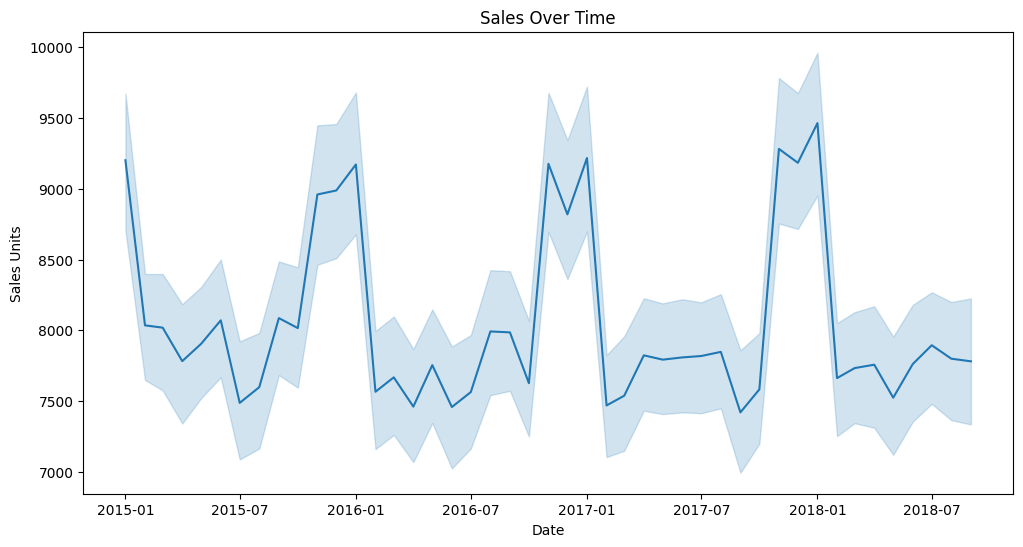

In [5]:
# Step 3: EDA
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Sales_Units', data=df)
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Units')
plt.show()

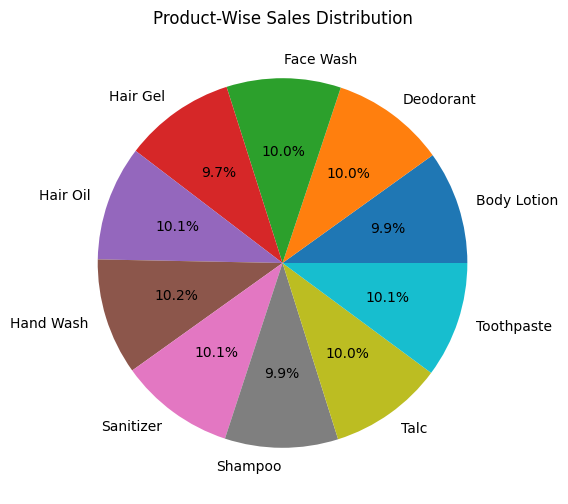

In [6]:
# Pie Chart
product_sales = df.groupby('Product')['Sales_Units'].sum()
plt.figure(figsize=(6, 6))
plt.pie(product_sales, labels=product_sales.index, autopct='%1.1f%%')
plt.title('Product-Wise Sales Distribution')
plt.show()

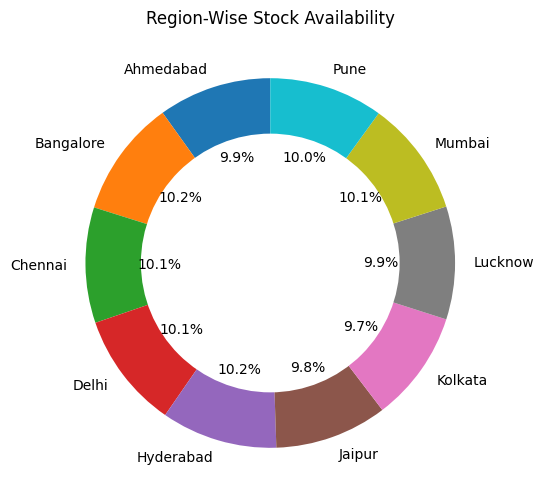

In [7]:
# Donut Chart
region_stock = df.groupby('Region')['Stock_Available'].sum()
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(region_stock, labels=region_stock.index, autopct='%1.1f%%', startangle=90)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)
plt.title('Region-Wise Stock Availability')
plt.show()

In [10]:
# Step 4: Preprocessing
le = LabelEncoder()
df['Product'] = le.fit_transform(df['Product'])
df['Region'] = le.fit_transform(df['Region'])
df['Sales_Channel'] = le.fit_transform(df['Sales_Channel'])
scaler = MinMaxScaler()
df['scaled_sales'] = scaler.fit_transform(df[['Sales_Units']])
features = ['Product', 'Region', 'Sales_Channel', 'Profit_Percent', 'Discount_Percent', 'Stock_Available']
X = df[features]
y = df['Sales_Units']
df = df.dropna(subset=['Sales_Units'])
X = df[features]
y = df['Sales_Units']

In [11]:
# Step 5: Machine Learning Models
models_ml = {
    'Random Forest': RandomForestRegressor(),
    'Ridge': Ridge(),
    'SVR': SVR()
}
ts = TimeSeriesSplit(n_splits=5)

for name, model in models_ml.items():
    grid = GridSearchCV(model, {}, cv=ts, scoring='r2')
    grid.fit(X, y)
    pred = grid.predict(X)
    print(f"{name} R2 Score:", r2_score(y, pred))


Random Forest R2 Score: 0.8538967154017834
Ridge R2 Score: 0.00032177386823928344
SVR R2 Score: -5.272654803012422e-05


In [12]:
# Step 6: Deep Learning Models
window_size = 30
series = df['scaled_sales'].values
X_dl, y_dl = [], []
for i in range(window_size, len(series)):
    X_dl.append(series[i - window_size:i])
    y_dl.append(series[i])
X_dl = np.array(X_dl)
y_dl = np.array(y_dl)
X_dl = X_dl.reshape((X_dl.shape[0], X_dl.shape[1], 1))
split = int(0.8 * len(X_dl))
X_train_dl, X_test_dl = X_dl[:split], X_dl[split:]
y_train_dl, y_test_dl = y_dl[:split], y_dl[split:]

In [13]:
# LSTM
model_lstm = Sequential([LSTM(64, input_shape=(window_size, 1)), Dropout(0.2), Dense(1)])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train_dl, y_train_dl, epochs=10, validation_data=(X_test_dl, y_test_dl))
pred_lstm = model_lstm.predict(X_test_dl)

Epoch 1/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0763 - val_loss: 0.0617
Epoch 2/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0658 - val_loss: 0.0617
Epoch 3/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0654 - val_loss: 0.0626
Epoch 4/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0650 - val_loss: 0.0613
Epoch 5/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0655 - val_loss: 0.0618
Epoch 6/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0646 - val_loss: 0.0613
Epoch 7/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0661 - val_loss: 0.0636
Epoch 8/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0655 - val_loss: 0.0616
Epoch 9/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0652 - val_loss: 0.0613
Epoch 10/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0648 - val_loss: 0.0613
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [14]:
# GRU
model_gru = Sequential([GRU(64, input_shape=(window_size, 1)), Dropout(0.2), Dense(1)])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_train_dl, y_train_dl, epochs=10, validation_data=(X_test_dl, y_test_dl))
pred_gru = model_gru.predict(X_test_dl)

Epoch 1/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0784 - val_loss: 0.0629
Epoch 2/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0660 - val_loss: 0.0614
Epoch 3/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0668 - val_loss: 0.0622
Epoch 4/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0652 - val_loss: 0.0614
Epoch 5/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0650 - val_loss: 0.0614
Epoch 6/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0661 - val_loss: 0.0616
Epoch 7/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0652 - val_loss: 0.0613
Epoch 8/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0644 - val_loss: 0.0615
Epoch 9/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0655 - val_loss: 0.0615
Epoch 10/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0641 - val_loss: 0.0612
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [15]:
# Dense
model_dense = Sequential([Dense(64, input_shape=(window_size, 1)), Dropout(0.2), Dense(1)])
model_dense.compile(optimizer='adam', loss='mse')
model_dense.fit(X_train_dl, y_train_dl, epochs=10, validation_data=(X_test_dl, y_test_dl))
pred_dense = model_dense.predict(X_test_dl)

Epoch 1/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0915 - val_loss: 0.0620
Epoch 2/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0676 - val_loss: 0.0618
Epoch 3/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0666 - val_loss: 0.0617
Epoch 4/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0653 - val_loss: 0.0623
Epoch 5/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0652 - val_loss: 0.0616
Epoch 6/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0657 - val_loss: 0.0616
Epoch 7/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0655 - val_loss: 0.0617
Epoch 8/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0651 - val_loss: 0.0619
Epoch 9/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0643 - val_loss: 0.0617
Epoch 10/10
447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0648 - val_loss: 0.0617
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [16]:
# Evaluate DL models
def evaluate_dl(name, y_true, y_pred):
    y_true_inv = scaler.inverse_transform(y_true.reshape(-1, 1))
    # Reshape y_pred to 2D for inverse_transform if it's 3D
    # Take only the last prediction from each sequence for Dense model
    y_pred_inv = scaler.inverse_transform(y_pred[:, -1, :].reshape(-1, 1) if y_pred.ndim == 3 else y_pred)
    score = r2_score(y_true_inv, y_pred_inv)
    print(f"{name} R2 Score:", score)

evaluate_dl("LSTM", y_test_dl, pred_lstm)
evaluate_dl("GRU", y_test_dl, pred_gru)
evaluate_dl("Dense", y_test_dl, pred_dense)

LSTM R2 Score: 0.004358456996552795
GRU R2 Score: 0.005908352222064206
Dense R2 Score: -0.0005431954466263988


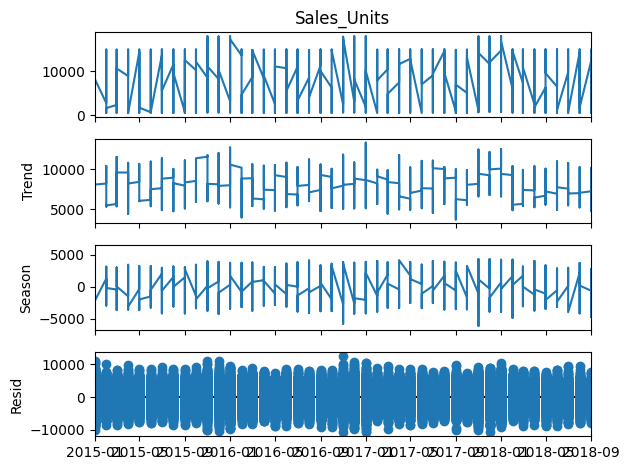

In [17]:
# Step 7: STL Decomposition
stl_series = df.set_index('Date')['Sales_Units']
stl = STL(stl_series, seasonal=13, period=12) # Replace 12 with the actual period
result = stl.fit()
fig = result.plot()
plt.show()

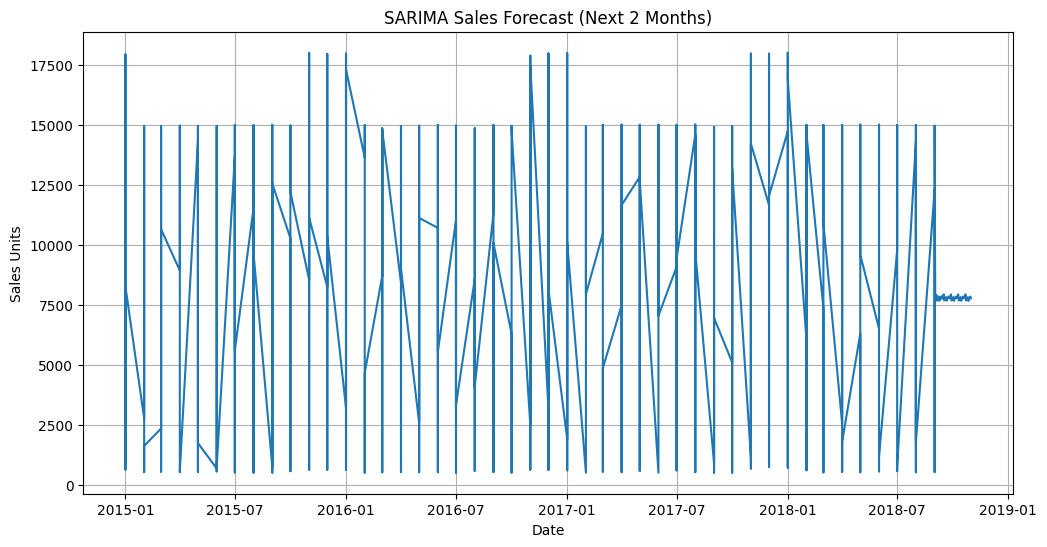

In [18]:
# Step 8: SARIMA Forecasting
sarima_model = SARIMAX(stl_series, order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_fit.forecast(steps=60)
future_dates = pd.date_range(stl_series.index[-1], periods=61, freq='D')[1:]
combined_series = pd.concat([stl_series, pd.Series(sarima_forecast.values, index=future_dates)])
plt.figure(figsize=(12, 6))
plt.plot(combined_series)
plt.title('SARIMA Sales Forecast (Next 2 Months)')
plt.xlabel('Date')
plt.ylabel('Sales Units')
plt.grid(True)
plt.show()

In [19]:
# Step 9: Compare Model Performance (ML + DL)
model_scores = {
    'Random Forest': r2_score(y, RandomForestRegressor().fit(X, y).predict(X)),
    'Ridge': r2_score(y, Ridge().fit(X, y).predict(X)),
    'SVR': r2_score(y, SVR().fit(X, y).predict(X)),
    'LSTM': r2_score(scaler.inverse_transform(y_test_dl.reshape(-1,1)), scaler.inverse_transform(pred_lstm)),
    'GRU': r2_score(scaler.inverse_transform(y_test_dl.reshape(-1,1)), scaler.inverse_transform(pred_gru)),
    # Take the last prediction from each sequence for the Dense model
    'Dense': r2_score(scaler.inverse_transform(y_test_dl.reshape(-1,1)), scaler.inverse_transform(pred_dense[:, -1, :].reshape(-1, 1)))
}

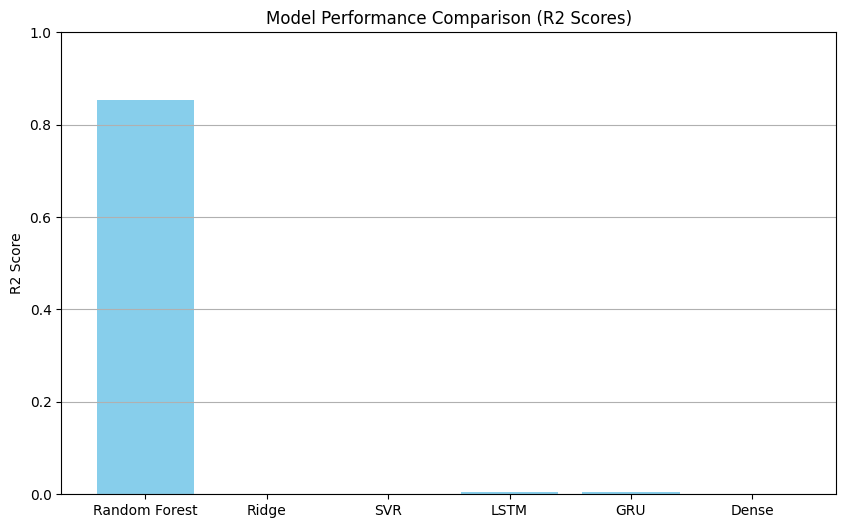

In [20]:
plt.figure(figsize=(10,6))
plt.bar(model_scores.keys(), model_scores.values(), color='skyblue')
plt.title('Model Performance Comparison (R2 Scores)')
plt.ylabel('R2 Score')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()